<a href="https://colab.research.google.com/github/NozdryakovaMarina/labpy_5/blob/main/lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import csv
import random
import glob
import shutil
from typing import Any, Tuple, List

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def create_csv(type_name: str, csv_name: str, dir_name: str) -> None:
    """
    The function creates a csv file and writes information from the dataset into it
    """
    abs_path = os.path.abspath(dir_name)
    rel_path = os.path.relpath(dir_name)
    img_f = os.listdir(os.path.join(abs_path, type_name))
    with open(csv_name, 'a') as f_csv:
        writer = csv.writer(f_csv, delimiter=',', lineterminator='\r')
        for img in img_f:
            writer.writerow([os.path.join(abs_path, type_name, img),
                             os.path.join(rel_path, type_name, img), type_name])


def create_csvfile(namecsv: str) -> None:
    """
    The function takes as input the name for the .csv file,
    creates a .csv file with the passed name and writes the column headers.
    """
    with open(namecsv, "w", newline="") as f:
        writer = csv.writer(f, delimiter=",", lineterminator="\r")
        writer.writerow(["Absolute path", "Relative path", "Class name"])


def main() -> None:

    create_csvfile('annotation1.csv')
    create_csv('polar_bear', 'annotation1.csv', '/content/drive/MyDrive/lab_py5/dataset/')
    create_csv('brown_bear', 'annotation1.csv', '/content/drive/MyDrive/lab_py5/dataset/')


if __name__ == "__main__":
    main()

**Создание класса для загрузки и обработки данных изображений из CSV-файла и предоставления доступа к отдельным образцам для обучения, тестирования или валидации.**

In [3]:
class ImageDataset(Dataset):
  def __init__(self, path_to_annotation_file: str, transform: Any=None, train: bool=False, test: bool=False, valid: bool=False) -> None:
    self.path_to_annotation_file = path_to_annotation_file
    self.data = self.get_data(path_to_annotation_file, train, test, valid)
    self.transform = transform

  def get_data(self, path_to_annotation_file: str, train: bool=False, test: bool=False, valid: bool=False) -> pd.DataFrame:
    data = pd.read_csv(path_to_annotation_file, usecols=(0, 2), names = ('path_to_iamge', 'label'))
    data = data.sample(frac=1).reset_index(drop=True)
    data['label'] = data['label'].apply(lambda l: 0 if l == 'polar_bear' else 1)
    train_size = int(0.8 * data.shape[0])
    test_valid_size = int(0.1 * data.shape[0])
    if train == True:
      data = data.iloc[:train_size, :]
    elif test == True:
      data = data.iloc[train_size:train_size + test_valid_size, :]
    elif valid == True:
      data = data.iloc[train_size + test_valid_size:, :]
    return data

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
    path_to_image = self.data.iloc[index, 0]
    image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
    label = self.data.iloc[index, 1]

    if self.transform:
      image = self.transform(image)

    return image, label


**Устанавливание последовательности преобразований изображений с помощью torchvision.transforms.Compose**

In [4]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)),ъекта
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                    torchvision.transforms.RandomHorizontalFlip(p=0.5)])

**Создание экземпляров класса ImageDataset**

In [5]:
train_data = ImageDataset(path_to_annotation_file='/content/drive/MyDrive/lab_py5/annotation1.csv', transform=transforms, train = True)
test_data = ImageDataset(path_to_annotation_file='/content/drive/MyDrive/lab_py5/annotation1.csv', transform=transforms, test = True)
valid_data = ImageDataset(path_to_annotation_file='/content/drive/MyDrive/lab_py5/annotation1.csv', transform=transforms, valid = True)

**Получение количества выборок в наборах данных обучения, тестирования и валидации. Проверка сбалансированности.**

In [6]:
len(train_data), len(test_data), len(valid_data)

(1762, 220, 221)

In [7]:
train_data.data['label'].value_counts()

0    887
1    875
Name: label, dtype: int64

In [8]:
test_data.data['label'].value_counts()

0    114
1    106
Name: label, dtype: int64

In [9]:
valid_data.data['label'].value_counts()

1    112
0    109
Name: label, dtype: int64

**Создание экземпляров DataLoader для обучающих и тестовых наборов данных с указанными размерами пакетов и настройками перемешивания.**

In [10]:
train_loader = DataLoader(dataset=train_data, batch_size=4, shuffle = True)
test_loader = DataLoader(dataset=test_data, batch_size=4, shuffle=False)

**Визуализирует пакета обучающих данных.**

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0 torch.Size([4, 3, 224, 224])


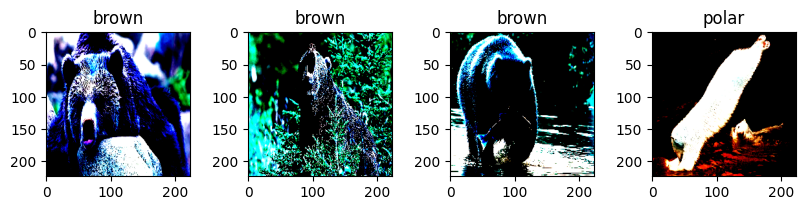

In [11]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(top= 0.85, bottom=0.1, wspace=0.4, hspace=0.4, right=0.85, left=0.1)

for i_batch, sample_batched in enumerate(train_loader):
    if i_batch == 1:
      break

    print(i_batch, sample_batched[0].shape)

    for j in range(4):
      plt.subplot(1, 4, j + 1)
      plt.title("polar" if sample_batched[1][j] == 0 else "brown")
      plt.imshow(sample_batched[0][j].permute(1, 2, 0).numpy()[:, :, ::-1])

**Сверточная нейросеть**

In [12]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2)
        self.conv_2 = nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fc_1 = nn.Linear(5408, 10)
        self.fc_2 = nn.Linear(10, 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = torch.nn.Flatten()(output)
        output = self.relu(self.fc_1(output))
        output = torch.nn.Sigmoid()(self.fc_2(output))
        return output


**Задание количества тренировочных объектов и скорости обучения**

In [33]:
# parameters = {'lr': [0.0001, 0.001, 0.01],
#               'batch_size' : [16, 32, 48]}

# parameters = {'lr': [0.001, 0.01],
#               'batch_size' : [160]}

parameters = {'lr': [0.001, 0.01, 0.1],
              'batch_size' : [160, 320, 480]}

**Цикл обучения(train loop).**
**С выводом графиков для значения функции потерь**

Epoch 1
Epoch 1 end
Epoch: 1, train_accuracy: 0.8399545970488081, train_loss: 0.38721126317977905
Epoch: 1, valid_accuracy: 0.9366515837104072, valid_loss: 0.14568501710891724
Epoch 2
Epoch 2 end
Epoch: 2, train_accuracy: 0.9375709421112373, train_loss: 0.16849353909492493
Epoch: 2, valid_accuracy: 0.9638009049773755, valid_loss: 0.07883655279874802
Epoch 3
Epoch 3 end
Epoch: 3, train_accuracy: 0.9494892167990919, train_loss: 0.13601553440093994
Epoch: 3, valid_accuracy: 0.9773755656108598, valid_loss: 0.10009221732616425
Epoch 4
Epoch 4 end
Epoch: 4, train_accuracy: 0.9580022701475596, train_loss: 0.11650323867797852
Epoch: 4, valid_accuracy: 0.9728506787330318, valid_loss: 0.09391210973262787
Epoch 5
Epoch 5 end
Epoch: 5, train_accuracy: 0.9642451759364359, train_loss: 0.1019228994846344
Epoch: 5, valid_accuracy: 0.9728506787330318, valid_loss: 0.07449758052825928
Epoch 6
Epoch 6 end
Epoch: 6, train_accuracy: 0.9636776390465381, train_loss: 0.0970022901892662
Epoch: 6, valid_accuracy

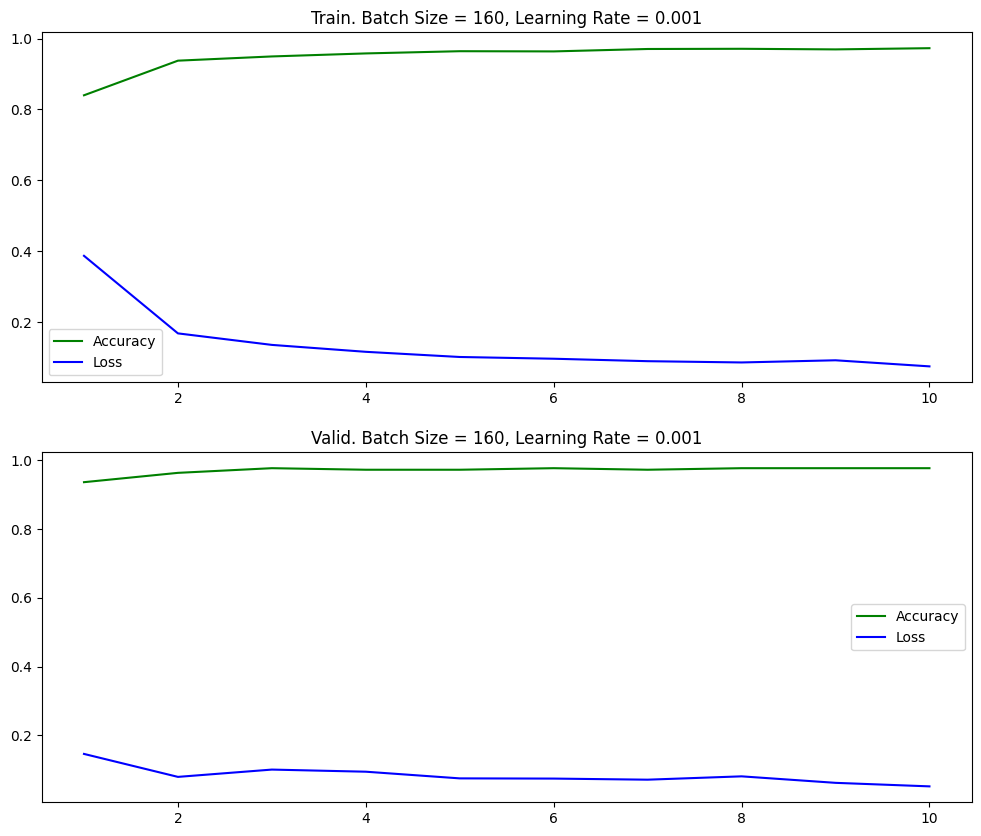

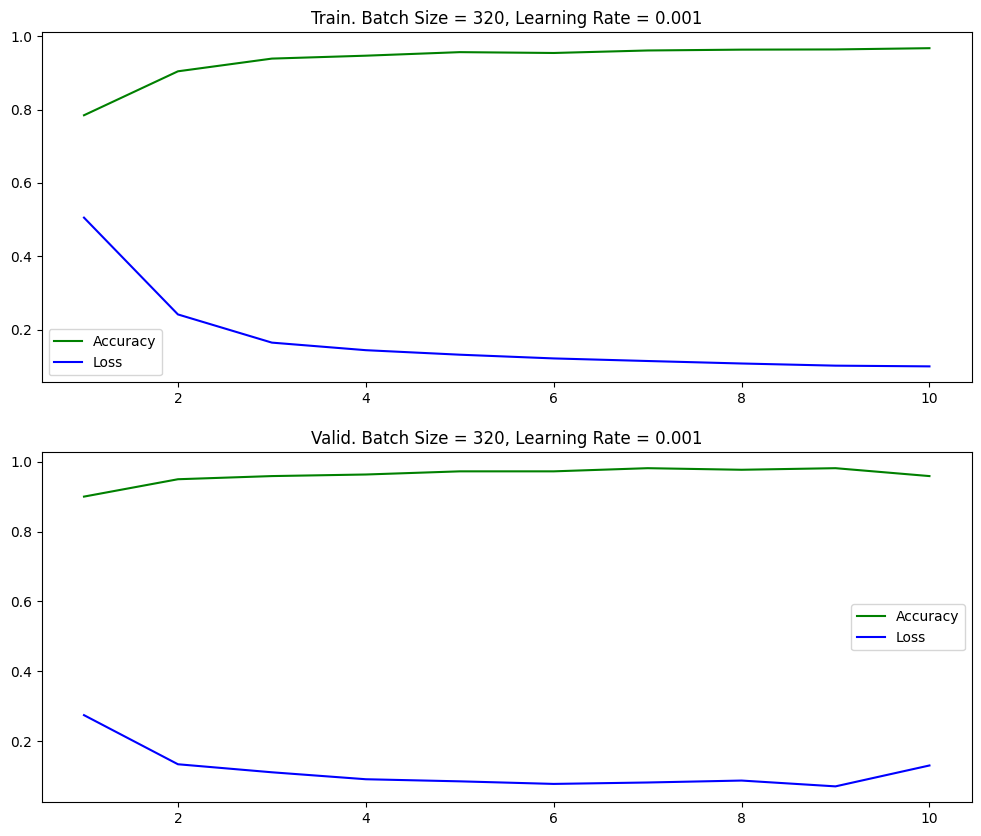

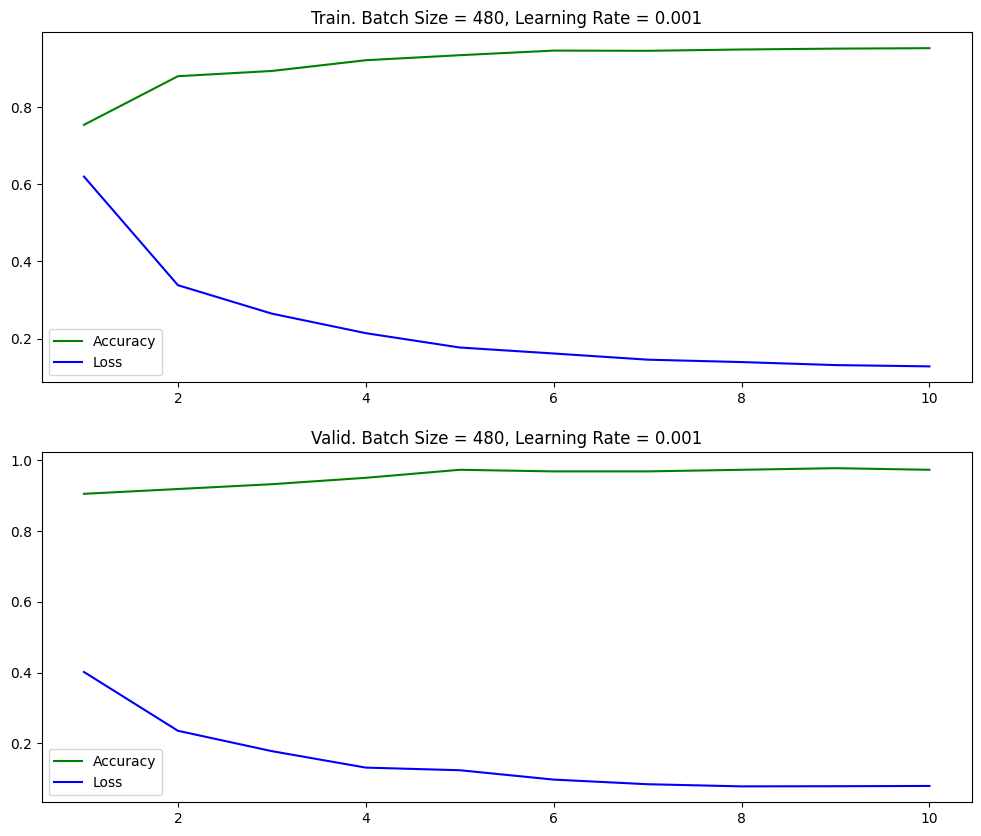

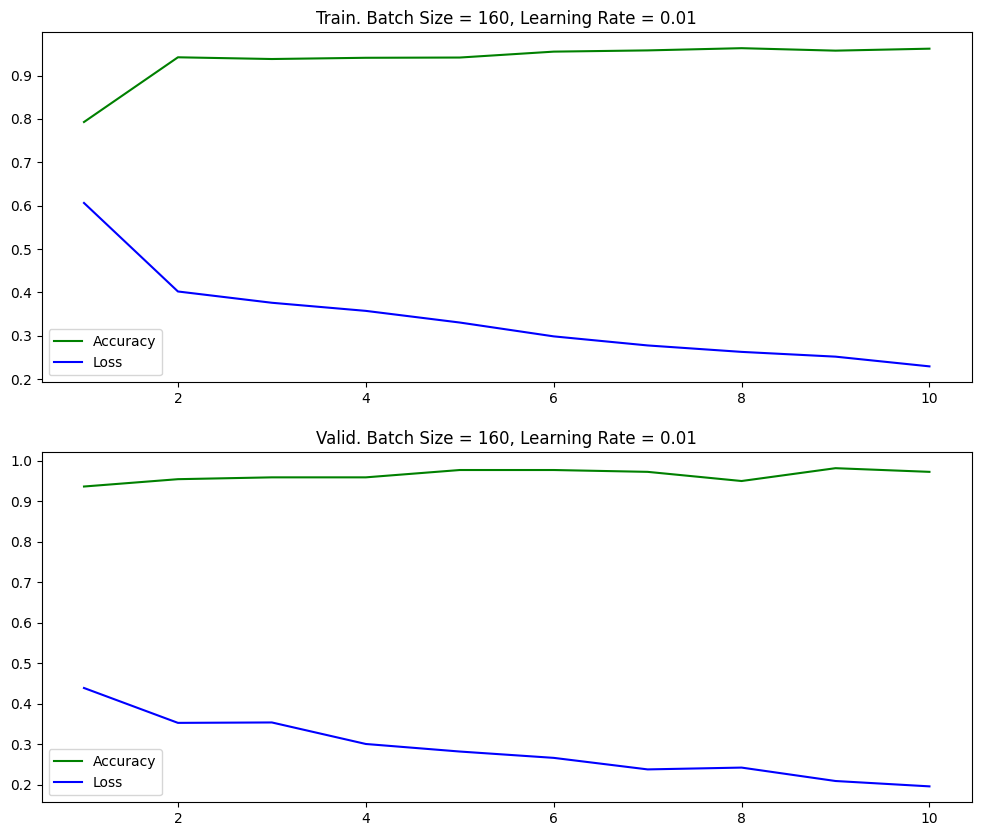

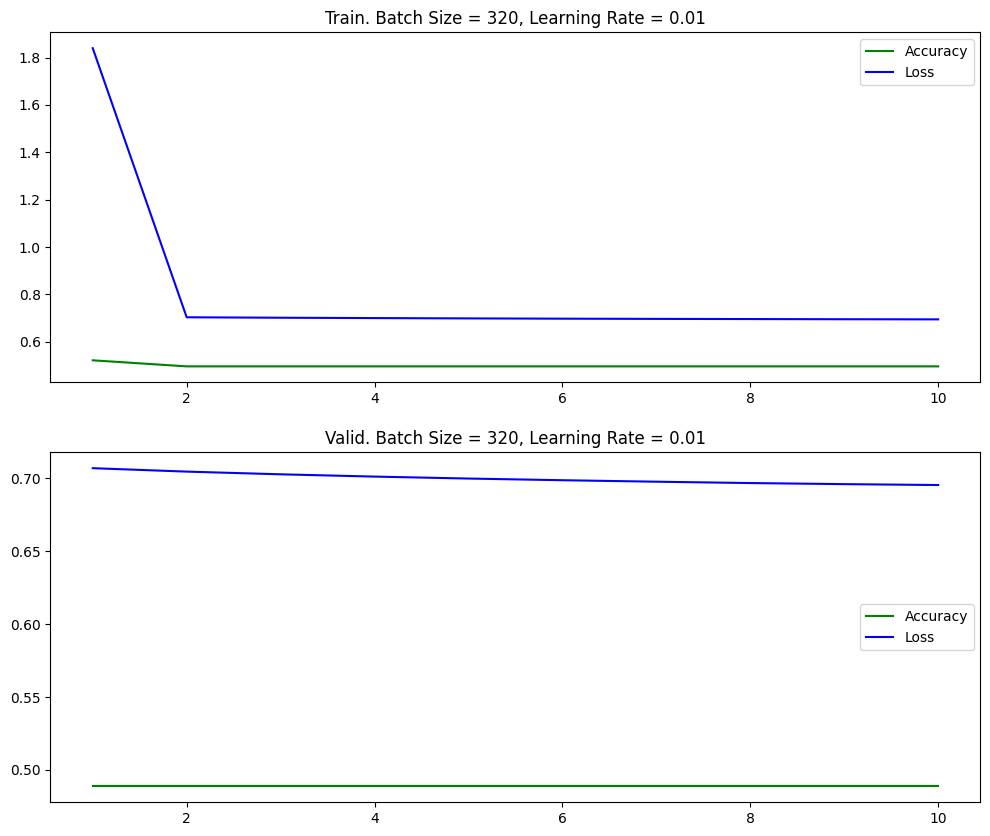

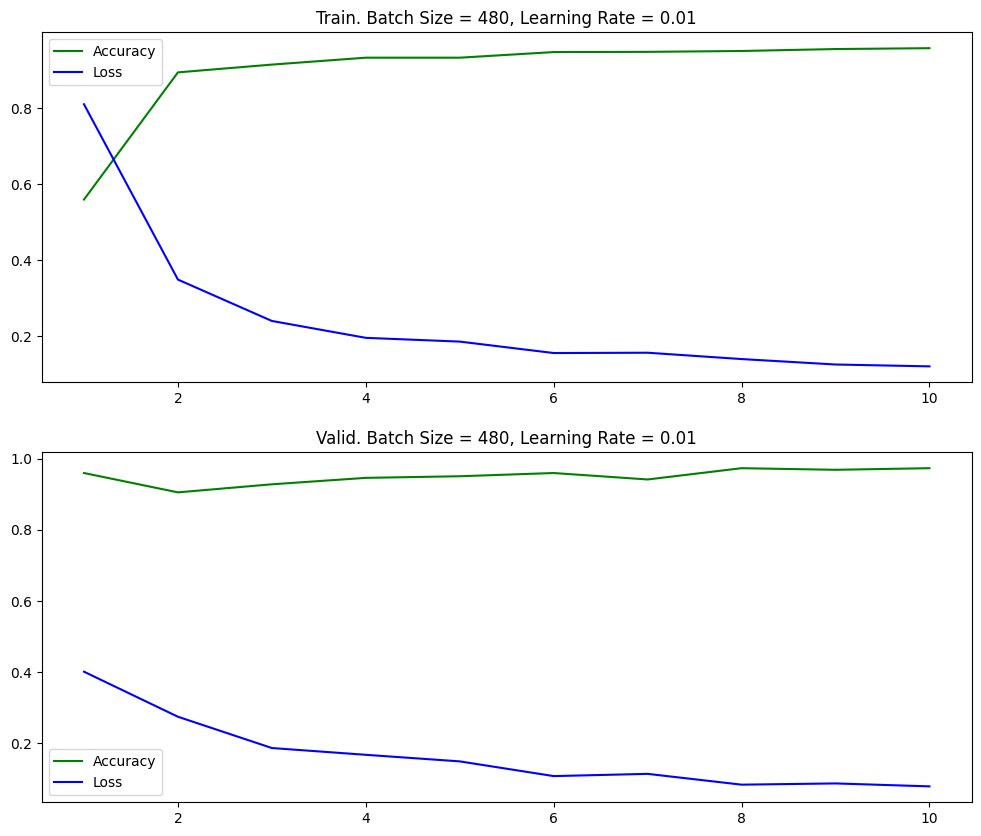

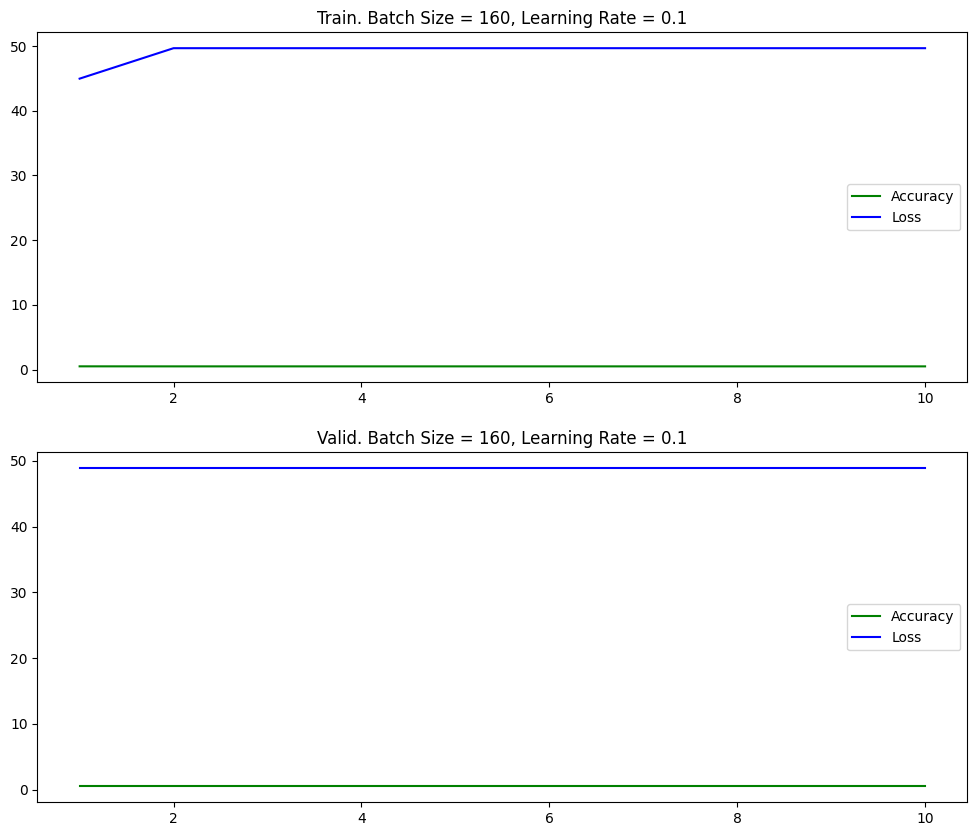

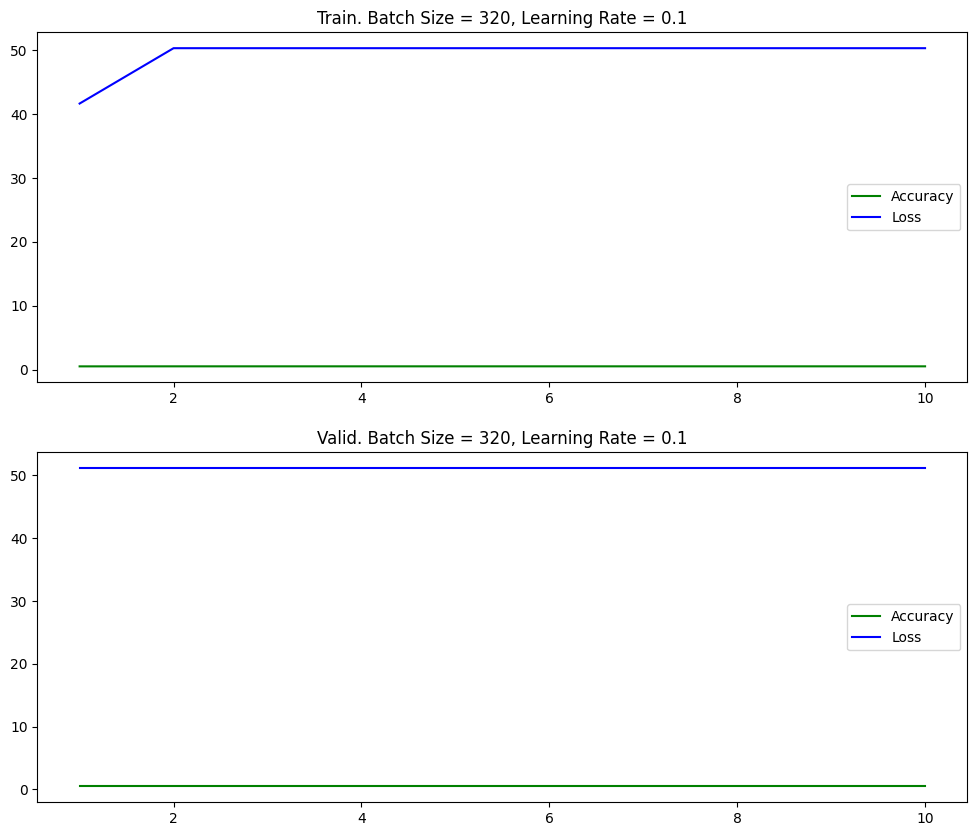

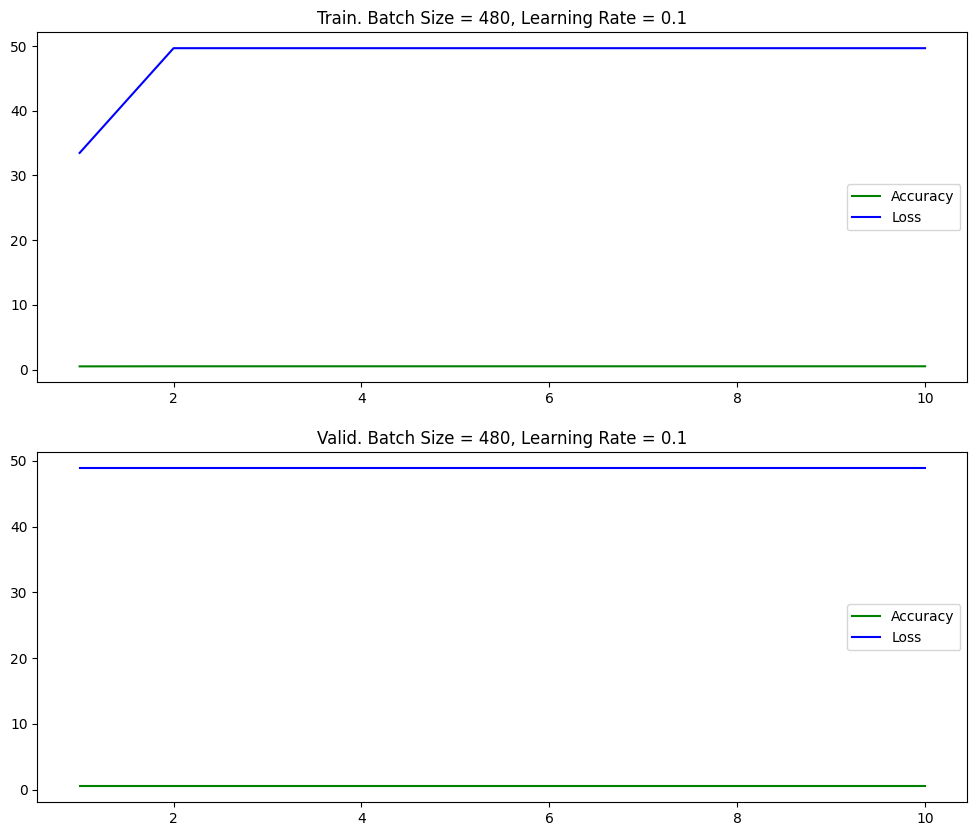

In [34]:
for lr in parameters['lr']:
    for bs in parameters['batch_size']:
        device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        model = CNN().to(device)

        optimizer = optim.Adam(params=model.parameters(), lr=lr)
        criterion = nn.BCELoss(reduction='sum')

        train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle = True)
        test_loader = DataLoader(dataset=test_data, batch_size=bs, shuffle = False)
        valid_loader = DataLoader(dataset=valid_data, batch_size=bs, shuffle = False)

        epochs = 10

        train_accuracy_values = []
        train_loss_values = []

        val_accuracy_values = []
        val_loss_values = []

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}")
            model.train()
            epoch_loss = 0
            epoch_accuracy = 0

            epoch_val_loss = 0
            epoch_val_accuracy = 0

            for data, label in train_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_accuracy += acc / len(train_data)
                epoch_loss += loss / len(train_data)

            model.eval()
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_val_accuracy += acc / len(valid_data)
                epoch_val_loss += loss / len(valid_data)

            val_accuracy_values.append(epoch_val_accuracy)
            val_loss_values.append(epoch_val_loss)

            train_accuracy_values.append(epoch_accuracy)
            train_loss_values.append(epoch_loss)

            print(f"Epoch {epoch + 1} end")

            print('Epoch: {}, train_accuracy: {}, train_loss: {}'.format(epoch + 1, epoch_accuracy, epoch_loss))
            print('Epoch: {}, valid_accuracy: {}, valid_loss: {}'.format(epoch + 1, epoch_val_accuracy, epoch_val_loss))

        train_loss_values = [value.cpu().detach().numpy() for value in train_loss_values]
        val_loss_values = [value.cpu().detach().numpy() for value in val_loss_values]

        plt.figure(figsize=(12,10))

        plt.subplot(2, 1, 1)
        plt.title(f"Train. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), train_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), train_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        plt.subplot(2, 1, 2)
        plt.title(f"Valid. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), val_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), val_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        #model.eval()
        test_loss = 0
        test_accuracy = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

            acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

            test_accuracy+=acc / len(test_data)
            test_loss += float(loss.detach()) / len(test_data)

        torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/lab_py5", f"bs{bs}_lr{lr}_weight.pt"))

        print('LR: {}, BS: {}, test_accuracy: {}, test_loss: {}'.format(lr, bs, test_accuracy, test_loss))

**Значение точности и функции потерь на тестовой выборке**

In [ ]:
test_accuracy, test_loss

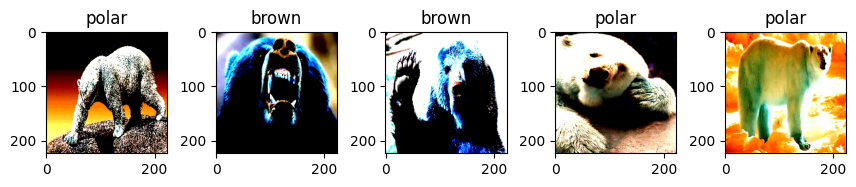

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(top= 0.8, bottom=0.1, wspace=0.4, hspace=0.4, right=0.9, left=0.1)

for j in range(5):
  index = random.randint(0, 200)
  plt.subplot(1, 5, j + 1)
  plt.title("polar" if (1 if  model(test_data[index][0].unsqueeze(dim=0).to(device))[0] >= 0.5 else 0) == 0 else "brown")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])

# **Сохранение и загрузка модели**

In [ ]:
torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/lab_py5/dataset", "weight.pt"))

In [ ]:
model = CNN()
model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/lab_py5/dataset", "weight.pt")))
model.to(device)

CNN(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=5408, out_features=10, bias=True)
  (fc_2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model.eval()

test_loss = 0
test_accuracy = 0

for data, label in test_loader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum()
    test_accuracy += acc / len(test_data)
    test_loss += float(loss.detach()) / len(test_data)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
test_accuracy, test_loss

(0.9272727272727276, 0.34359027668833736)

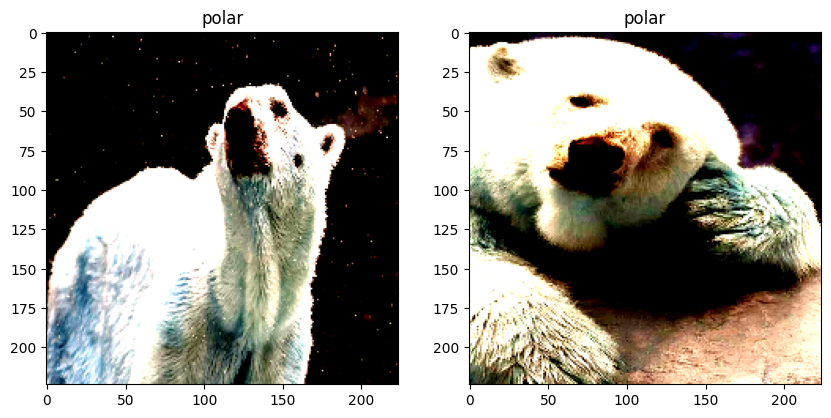

In [ ]:
plt.figure(figsize=(10, 5))

for j in range(2):
  index = random.randint(0, 200)
  plt.subplot(1, 2, j + 1)
  plt.title("polar" if (1 if  model(test_data[index][0].unsqueeze(dim=0).to(device))[0] >= 0.5 else 0) == 0 else "brown")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])